## Player Clustering (In this part I also used chatGPT's help)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

# Load the dataset
data = pd.read_csv('enriched_mid_elo_games.csv')

# Select features for clustering
features = [
    'white_elo',
    'white_total_wins',
    'white_total_losses',
    'eco',
    'termination'
]

# Create a player-level dataset by aggregating unique White players
player_data = data[features + ['white']].drop_duplicates(subset=['white'])

# Filter eco to top 10 most frequent codes
top_eco = player_data['eco'].value_counts().head(10).index
player_data['eco'] = player_data['eco'].where(player_data['eco'].isin(top_eco), 'other')

# Handle missing values and impute 0s with median for total wins/losses
for col in ['white_total_wins', 'white_total_losses']:
    median_value = player_data[player_data[col] != 0][col].median()
    player_data[col] = player_data[col].replace(0, median_value)
    player_data[col] = player_data[col].fillna(median_value)

# Impute missing white_elo with median
player_data['white_elo'] = player_data['white_elo'].fillna(player_data['white_elo'].median())

# Impute missing categorical values with mode
for col in ['eco', 'termination']:
    player_data[col] = player_data[col].fillna(player_data[col].mode()[0])

# Encode categorical variables
player_data = pd.get_dummies(player_data, columns=['eco', 'termination'], drop_first=True)

# Drop the 'white' column
player_data = player_data.drop(columns=['white'])

# Standardize numerical features
numerical_cols = ['white_elo', 'white_total_wins', 'white_total_losses']
scaler = StandardScaler()
player_data[numerical_cols] = scaler.fit_transform(player_data[numerical_cols])

## Determine optimal number of clusters using elbow method

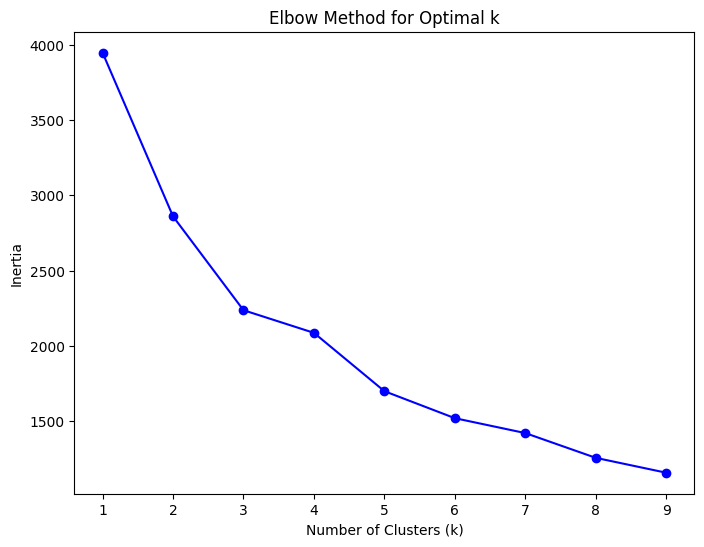

In [2]:
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(player_data)
    inertia.append(kmeans.inertia_)

# Plot elbow curve (to screen)
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### Apply k-means with chosen number of clusters & Reduce dimensions for visualization using PCA

In [3]:
kmeans = KMeans(n_clusters=4, random_state=42)
player_data['cluster'] = kmeans.fit_predict(player_data)


pca = PCA(n_components=2)
pca_result = pca.fit_transform(player_data.drop(columns=['cluster']))
player_data['pca1'] = pca_result[:, 0]
player_data['pca2'] = pca_result[:, 1]

## Visualize clusters and Analyze 

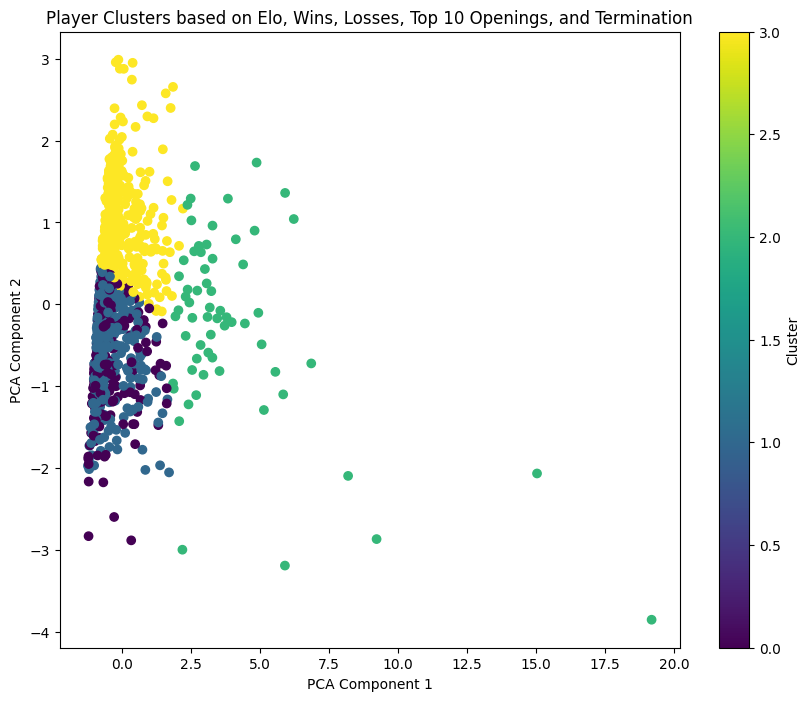

Cluster Summary:
         white_elo  white_total_wins  white_total_losses   eco_A40   eco_B00  \
cluster                                                                        
0        -0.646585         -0.270396           -0.217039  0.095420  0.038168   
1        -0.654777         -0.249972           -0.194305  0.000000  0.000000   
2         0.494247          2.959775            2.657943  0.015873  0.031746   
3         1.003057         -0.098232           -0.135534  0.028571  0.037143   

          eco_B01   eco_B20   eco_C00   eco_C20   eco_C41   eco_D00   eco_D02  \
cluster                                                                         
0        0.114504  0.125954  0.118321  0.083969  0.133588  0.099237  0.072519   
1        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2        0.047619  0.000000  0.079365  0.031746  0.031746  0.031746  0.015873   
3        0.028571  0.025714  0.045714  0.008571  0.048571  0.011429  0.022857   

         eco_ot

In [4]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(player_data['pca1'], player_data['pca2'], c=player_data['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Player Clusters based on Elo, Wins, Losses, Top 10 Openings, and Termination')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Cluster characteristics
cluster_summary = player_data.groupby('cluster').mean()
print("Cluster Summary:")
print(cluster_summary)

# Print column names for reference
print("Columns in cluster_summary:")
print(cluster_summary.columns.tolist())

# Cluster Summary Analysis (Mid Elo Players)

This section analyzes clusters generated from a **mid-Elo player** dataset using standardized features such as Elo rating, win/loss stats, ECO opening codes, and game termination types.

---

## Cluster Overview and Interpretation

### **Cluster 0 – Classical Mid-Level Players**
- **White Elo**: -0.65 → Slightly below average
- **Wins/Losses**: Below average but balanced
- **Openings**: Broad usage (notably B01, B20, C00, C20, C41, D00, D02)
- **Termination**:
  - Normal: 0.77 (very high)
  - Time forfeit: 0.23
- **PCA Components**:
  - `pca1`: -0.47
  - `pca2`: -0.61
- **Interpretation**:  
  Steady mid-level players with traditional strategies and well-rounded game completion. They avoid blunders and timeouts and stick to common opening theory.

---

### **Cluster 1 – Passive or Sparse Cluster**
- **White Elo**: -0.65 → Slightly below average
- **Wins/Losses**: Also below average
- **Openings**: All zero → Possibly **incomplete data** or **non-standard games**
- **Termination**:
  - Normal: 0.81 (highest)
  - Time forfeit: 0.19
- **PCA Components**:
  - `pca1`: -0.43
  - `pca2`: -0.56
- **Interpretation**:  
  Likely **anomalous or very passive players**. Could represent users who resign quickly, don’t follow common openings, or the cluster could be due to preprocessing issues.

---

### **Cluster 2 – Aggressive and Successful Players**
- **White Elo**: 0.49 → Above average
- **Wins**: 2.96, **Losses**: 2.66 → Stronger than average
- **Openings**: Includes C00, D00, C41; less emphasis on B-lines
- **Termination**:
  - Normal: 0.62
  - Time forfeit: 0.38
- **PCA Components**:
  - `pca1`: 3.99 (high)
  - `pca2`: -0.25
- **Interpretation**:  
  Active, stronger players in this Elo band. They lean toward principled, structured openings and win more often. Their PCA indicates they stand out within the mid-Elo distribution.

---

### **Cluster 3 – Rising and Disciplined Players**
- **White Elo**: 1.00 → **Highest Elo** among clusters
- **Wins/Losses**: Slightly negative → not many games, but tight performance
- **Openings**: Focused on structured lines (C00, C41, D02)
- **Termination**:
  - Normal: 0.68
  - Time forfeit: 0.32
- **PCA Components**:
  - `pca1`: 0.03
  - `pca2`: 1.02
- **Interpretation**:  
  Likely **technically sound or improving players**, still not high in win count but Elo suggests smarter play. They're not frequent players but tend to use deeper theory openings.

---

## Summary Table

| Cluster | Summary Description             | Key Features                                               |
|---------|----------------------------------|------------------------------------------------------------|
| 0       | Classical mid-Elo players        | Common openings, high normal finishes, balanced stats      |
| 1       | Sparse/passive or anomalous      | Missing openings, very high normal finishes, low variance  |
| 2       | Successful mid-Elo players       | Higher Elo and win rate, tactical openings, aggressive     |
| 3       | Rising/intermediate strategists  | Highest Elo, disciplined play, technically sound choices   |

---